## Notes
---
+  Avoid hard-coding values when possible. You worked hard to scrape the data and save it to a dataframe. Use that dataframe in you code to retrieve values.

\*\*\*\*\**__Be aware of the difference between two-sided and one-sided tests__*\*\*\*\*\*
+  ONLY use two-sided tests when the alternate hypothesis is in the form of $\mu\neq a$
+  Use one-sided test when the alternate hypothesis in the form of $\mu \ge a$ or $\mu \le a$
+  You can use two-sided tests for the case of testing $\mu \ge a$ or $\mu \le a$; think about the conclusions you can draw

### Extra tips/info
+  I found the permutation for contingency table (Question 2) quite slow using nested loops. Using `np.bincount` helped accelerate the task. Lesson _re_-learned: use built-in `numpy`/`scipy`/`panda` functions when possible.

---

### Setup
Data collection steps adapted from Tutorial 2.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
# reading data for Manitoba and New Brunswick
# url for the report page
report_page = 'https://www.canada.ca/en/public-health/services/' + \
    'surveillance/respiratory-virus-detections-canada/' + \
    '2018-2019/respiratory-virus-detections-isolations-' + \
    'week-01-ending-january-5-2019.html'

# using pandas `read_html` 
df = pd.read_html(report_page) # returns a list of tables 
df[1] # by inspection we see that Table 2 is the second table

# select. rows corresponding to prov and territory
fludat = df[1].iloc[[
    0, 1, 2, 3, 11, 
    28, 29, 32, 33, 35, 
    36, 37, 38
],[0,1,2,3,4,5]]
fludat.columns = [
    'prov', 'total_tested',
    'H1N1_positive',
    'H3_positive',
    'other_positive',
    'total_positive'
]
fludat.iloc[:, 1:] = fludat.iloc[:, 1:].astype('int')
# Change province names so they match the names in the Wiki table
# `regex=True` allows you to use regular expressions
fludat = (
    fludat
    .replace('Province of', '', regex = True)
    .replace('Québec', 'Quebec', regex = True)
)
# Alberta, Ontario, Quebec, Sask have extra white space 
# in their names so remove
fludat['prov'] = fludat['prov'].str.strip()
# table for question 1
q1data = fludat.set_index('prov').loc[['New Brunswick', 'Manitoba']][[
    'total_tested', 'total_positive'
]]
q1data['flu_A_negative'] = (
    q1data['total_tested'] - q1data['total_positive']
).astype('int')

In [2]:
# read wiki page from the web store the table
wiki_page = 'https://en.wikipedia.org/wiki/List_of_regions_of_Canada'
df = pd.read_html(
    wiki_page, 
    header=0, # since the html does not tag (<th>) 
              # the first row as column, 
              # you need to manually specify it
    attrs = {"class":"wikitable"} # when you know specific html attributes 
                                  # of the table you want you can specify 
                                  # them here for a more specific query
)
# read the six region columns and prov/territories
regions = df[0][[
    'All provinces and territories', 
    'Six-region model[1]'
]].fillna(
    # propogate non-null values forward
    method = 'ffill', axis = 0 
).rename(columns={
    # rename columns
    "All provinces and territories": "prov", 
    "Six-region model[1]": "region"
}).replace(
    # rename the province name to match the other table
    ['Newfoundland and Labrador'], ['Newfoundland']
)
# Merge regions with flu data and only keep required columns
q2data = pd.merge(
    fludat, regions, on = 'prov'
)

# Question 1

Use the influnenza data from tutorial 2 to answer the following questions.

Is the proportion of of influenza cases in Manitoba different compared to New Brunswick?

(a) Conduct a permutation test to evaluate this question. What are the assumptions behind this test? What is the P-value?  What do you conclude?

In [3]:
# create arrays for each province 
# with positive cases coded as '1' 
# and negative cases as '0'
NB_cases = np.concatenate((
    np.repeat(1, q1data.iloc[0,1]), # positive cases for NB
    np.repeat(0, q1data.iloc[0,2])  # negative cases for NB
))
MB_cases = np.concatenate((
    np.repeat(1, q1data.iloc[1,1]), # positive cases for MB
    np.repeat(0, q1data.iloc[1,2])  # negative cases for MB
))
cases = np.concatenate((
    NB_cases, MB_cases
))
# label provinces (length should match the total tested)
provl = np.concatenate((
    np.repeat('NB', q1data.iloc[0,0]), 
    np.repeat('MB', q1data.iloc[1,0])
))

# sanity check (-:
NB_obs_p = sum(cases[provl=='NB'])/q1data.iloc[0,0]
MB_obs_p = sum(cases[provl=='MB'])/q1data.iloc[1,0]
diff = NB_obs_p - MB_obs_p # observed difference

print(
    'NB sample prop:\t', np.round(NB_obs_p,4), '\n' +
    'MB sample prop:\t', np.round(MB_obs_p,4), '\n' +
    'Observed diff:\t', np.round(diff,4)
)

NB sample prop:	 0.1775 
MB sample prop:	 0.1387 
Observed diff:	 0.0388


In [4]:
# Part (a)
def prop_perm_test(data):
    """
    return a single difference in proportion 
    from a random suffle of cases
    """
    shuffled = np.random.permutation(data) 
    # random.permutation returns the shuffled array 
    # vs. random.shuffle shuffles the array inplace
    prop_NB = shuffled[provl=='NB']      
    prop_MB = shuffled[provl =='MB']
    return prop_NB.mean() - prop_MB.mean()

N = 1000
np.random.seed(1234)
null_dist = [prop_perm_test(cases) for x in range(N)] 

tbar = np.mean(null_dist)
p_value2 = sum(
    np.absolute(null_dist - tbar) 
    >= np.absolute(diff - tbar)
)/N

The two-sided p-value is: 0.0


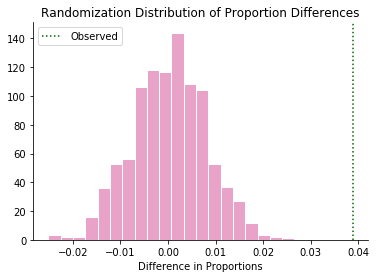

In [5]:
print('The two-sided p-value is:', np.round(p_value2,3))
# plot the distribution
fig = plt.figure()
plt.hist(
    null_dist,
    bins = 20, 
    color = '#e9a3c9',
    ec='white'
)
ax = fig.get_axes()[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
observed = plt.axvline(
    x=diff, color='darkgreen', linestyle=':', 
    label='Observed'
)
plt.xlabel('Difference in Proportions')
plt.title('Randomization Distribution of Proportion Differences')
plt.legend(loc='upper left');

(b) Conduct a Z-test to evaluate this question.  What are the assumptions behind this test? What is the P-value?  What do you conclude?

In [6]:
# Part (b)
from statsmodels.stats.proportion import proportions_ztest

nobs = np.array([q1data.iloc[0,0], q1data.iloc[1,0]]) #n_1, n_2
count = np.array([q1data.iloc[0,1], q1data.iloc[1,1]]) #X_1, X_2

obsZ, pval = proportions_ztest(
    count, nobs, alternative='two-sided'
)
print('The observed Z-value is:', np.round(obsZ,3))
print('The two-sided p-value is:', np.round(pval,3))

The observed Z-value is: 5.102
The two-sided p-value is: 0.0


#### Assumptions
For both tests, we assume the flu test result for each individual within each province are independent and identically distributed - i.e., exchangeable between individuals for permutation test. The proportional Z-test further assumes they are from binomial distributions.

#### Interpretation
The reported p-values are `0.0` for both tests and the null hypothesis is rejected based on 95% confidence level. That is, we conclude that the two proportions are different (in fact, we may conclude NB has higher proportion than Manitoba) 19 out of 20 times. 

# Question 2

In class 5 we discussed this example.

$$\begin{align*}
H_0 &: \text{region and and subtype of influenza are independent,} \\ 
H_a &: \text{region and subtype of influenza are dependent}.
\end{align*}$$


(a) Write a Python program to calculate the permutation distribution to test of independence of region and subtype of influenza. Create an appropriate visualization of this distribution. 

In [7]:
# Part (a)
from scipy.stats.contingency import expected_freq
fludat_region = q2data.iloc[:,[2,3,4,6]].groupby('region').sum()
print('Observed contingency table.')
display(fludat_region)
expected = expected_freq(fludat_region)
print('Expected contingency table.')
display(pd.DataFrame(
    np.rint(expected).astype('int'),
    columns=fludat_region.columns,
    index=fludat_region.index
))

def get_chisq_test(data, expected=None):
    """
    return the value test statistic value
    """
    if expected is None:
        expected = expected_freq(data)
    return np.array(
        pow(data - expected, 2)/expected
    ).sum()
# print observed test statistic
observed_chisq = get_chisq_test(fludat_region)
print(
    'Observed test statistic:', 
    round(observed_chisq, 2)
)

Observed contingency table.


,H1N1_positive,H3_positive,other_positive
region,,,
Atlantic,81,1,880
British Columbia,1010,75,755
Ontario,752,180,546
Prairies,4604,136,2775
Quebec,0,0,5974
Territories,162,3,6


Expected contingency table.


,H1N1_positive,H3_positive,other_positive
region,,,
Atlantic,354,21,586
British Columbia,678,41,1122
Ontario,544,33,901
Prairies,2768,165,4581
Quebec,2201,132,3642
Territories,63,4,104


Observed test statistic: 7584.81


In [8]:
# permutation distribution of the test statistic
def chisq_perm_shuffle(array1, array2, expected):
    """
    return a single value of chi squared test statistic
    from a single random shuffle
    """
    # shuffle
    np.random.shuffle(array1)
    # count
    counts = np.zeros((array2.max()+1, array1.max()+1))
    for arr1 in np.unique(array1):
        freq = np.bincount(array2[array1==arr1])
        counts[:len(freq), arr1] = freq # in case there is no region 5 
                                        # (the lengths would differ)
    return get_chisq_test(counts, expected)
    
    
def chisq_perm_test(data, expected, N=1000):
    """
    return a list of chi squared test statistics
    from random suffles
    """
    # create array of 0,1,2 for subtypes
    cases_by_subtype = []
    for ind, sub_positive in enumerate(data.sum(axis=0)):
        cases_by_subtype += list(np.repeat(ind, sub_positive))
    cases_by_subtype = np.array(cases_by_subtype)
    # create array of 0,1,...,5 for regions
    cases_by_region = []
    for ind, reg_positive in enumerate(data.sum(axis=1)):
        cases_by_region += list(np.repeat(ind, reg_positive))
    cases_by_region = np.array(cases_by_region)
    return [
        chisq_perm_shuffle(
            cases_by_subtype,
            cases_by_region, 
            expected
        ) 
        for x in range(N)
    ]

# randomly pemutate for N=1000 iterations
N = 1000
np.random.seed(1234)
null_dist_2 = chisq_perm_test(fludat_region, expected, N)

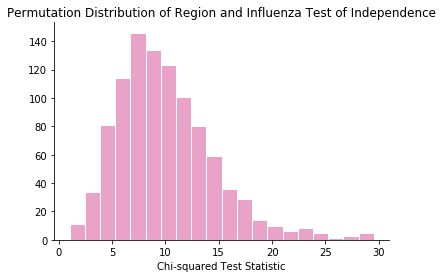

In [9]:
# plot the distribution
fig = plt.figure()
plt.hist(
    null_dist_2,
    bins = 20, 
    color = '#e9a3c9',
    ec='white'
)
ax = fig.get_axes()[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Chi-squared Test Statistic')
plt.title('Permutation Distribution of Region '+
          'and Influenza Test of Independence');

(b) Use the permutation distribution in (a) calculate the p-value of the test.

In [10]:
# Part (b)
p_value2 = (sum(
    (null_dist_2)
        >= np.absolute(observed_chisq)
)+1/(N+1))
print('The p-value is:', np.round(p_value2,3))

The p-value is: 0.001


(c) What can you conclude about region and subtype of influenza based on the results in part (b)? 

### Answer for Q2c
With p-value < `0.05`, the null hypothesis is rejected at 95% confidence level. In words, we conclude that the distribution of subtypes among positive influenza cases is not independent of the regions 19 out of 20 times.

# Question 3

This question involves investigating type I and II error rates for testing two proportions.  

(a) Explain how to simulate the type I error rate for a Z-test of two proportions.

### Answer for Q3a
1.  Simulate two independent sequence of `n` Bernoulli random variables from a common Bernoulli distribution.
2.  Perform Z-test and calculate the p-value based on a confidence level, `alpha`.
3.  Repeat `N` times and calculate proportion of times the p-value is less than `alpha`.

The simulation gives the proportion of time the null hypothesis (`p1=p2`) is rejected under null hypothesis (Type I error).

(b) Write a program in Python to simulate the type I error rate of the Z-test for two proportions.  What is your type I error rate for your simulation?  Assume the sample size in each group is 200 and $\alpha=0.05$.

In [11]:
from scipy.stats import bernoulli
np.random.seed(1234) #set random seed for replicability
alpha = 0.05 # alpha
p1 = 0.5 # Probability for population 1
p2 = 0.5 # Probability for population 2

nsamples = 200 #each test will use nsamples
nsims = 1000 #number of simulations from which to draw average

def sim_prop_test(p1,p2):
    testA = bernoulli(p1).rvs(nsamples)
    testB = bernoulli(p2).rvs(nsamples)
    count = np.array([testA.sum(), testB.sum()])
    nobs = np.array([nsamples, nsamples])
    rejected = (proportions_ztest(count, nobs)[1] <= 0.05)
    return rejected

print(
    'The simulated type I error rate is',
    str(np.round(np.mean([
        sim_prop_test(p1, p2) 
        for k in range(nsims)
    ]),3)) + '.'
)

The simulated type I error rate is 0.044.


(c) Explain how to simulate the power for testing two proportions.

### Answer for Q3c
1.  Simulate two independent sequence of `n` Bernoulli random variables from two different Bernoulli distributions.
2.  Perform Z-test and calculate the p-value based on a confidence level, `alpha`.
3.  Repeat `N` times and calculate proportion of times the p-value is less than `alpha`.

The simulation gives the proportion of time the null hypothesis (`p1=p2`) is rejected under alternate hypothesis.

(d) Write a program in Python to simulate the power of the Z-test for two proportions. What is the power and type II error rate for your simulation? Assume the sample size in each group is 200, $\alpha=0.05$, and the true proportion in one group is 0.45 and the true proportion in the other group is 0.57.

In [12]:
np.random.seed(1234)
p1 = 0.45 # Probability for population 1
p2 = 0.57 # Probability for population 2

rejected = [
        sim_prop_test(p1, p2) 
        for k in range(nsims)
    ]
print(
    'The simulated power is',
    str(np.round(np.mean(rejected),3)) + '.'
)
print(
    'The simulated power is',
    str(np.round(1-np.mean(rejected),3)) + '.'
)

The simulated power is 0.687.
The simulated power is 0.313.


# Question 4

Let $X$ be the number of purchases from and $n$ the number of visitors to the website.  The website owner is testing two versions of a web page on her site.  In a one-week period: 1874 visitors were randomized to page A, and 52 visitors made a purchase; and 1871 visitors were randomized to page B and 55 made a purchase. 


(a) Assume that the probability of a purchase is uniformly distributed.  Calculate the probability that the proportion of visitors to page B that make a purchase is greater than the proportion of visitors to page A.  

In [13]:
np.random.seed(1234)
nsim = 10000
purchased_A = np.random.beta(
    52+1,1874-52+1,nsim) # page A posterior dist
purchased_B = np.random.beta(
    55+1,1871-55+1,nsim) # page B posterior dist

print('The estimated probability is',
      str(np.round(
          sum(purchased_B > purchased_A)/nsim, # prob pB > pA
      3)) + '.')

The estimated probability is 0.62.


(b) Compare your result in (a) to a statistical hypothesis test.  Which test is more informative? Briefly explain.  

In [14]:
count = np.array([52, 55])
nobs = np.array([1874, 1871])
obsZ, pval = proportions_ztest(
    count, nobs, alternative='two-sided'
)
print('The observed Z-value is:', np.round(obsZ,3))
print('The two-sided p-value is:', np.round(pval,3))

The observed Z-value is: -0.303
The two-sided p-value is: 0.762


The Z-test for two proportions is conducted to test whether the difference between the two proportions is significant. 
$$ H_0: p_1=p_2 $$
$$ H_1: p_a\neq p_2$$

Based on the p-value, we fail to reject the null hypothesis at 95% confidence level and conclude that there isn't strong enough evidence that the two web pages promote sales differently.

#### Reasons why one would prefer one method over the other

##### Method (a) 
+  Assumes the difference between the two proportions is random. 
+  Thus, gives a probability over a binary decision. 

##### Method (b)
+  Assumes the _true_ difference is fixed.
+ Does not require a prior distribution - the uniform distribution assumed for making a purchase may not be realistic.